In [36]:
import pandas as pd
import numpy as np
from sklearn import datasets,set_config
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import sklearn
from IPython.display import display
import matplotlib.pyplot as plt
print(sklearn.__version__)

1.5.2


In [37]:
# Leer el archivo CSV
!curl -O "https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/car_data.csv"

df = pd.read_csv("car_data.csv")

# Opción 1: eliminar por índice de columna (la primera es 0, la novena es 8)
df = df.drop(df.columns[[0, 8]], axis=1)

# Verificar el resultado
print(df.head())


   Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type Seller_Type  \
0  2014           3.35           5.59       27000    Petrol      Dealer   
1  2013           4.75           9.54       43000    Diesel      Dealer   
2  2017           7.25           9.85        6900    Petrol      Dealer   
3  2011           2.85           4.15        5200    Petrol      Dealer   
4  2014           4.60           6.87       42450    Diesel      Dealer   

  Transmission    Set  
0       Manual  Train  
1       Manual  Train  
2       Manual  Train  
3       Manual  Train  
4       Manual   Test  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: CRYPT_E_NO_REVOCATION_CHECK (0x80092012) - La funci�n de revocaci�n no puede comprobar la revocaci�n para el certificado.


Primero, se debe separar el conjunto de datos en tres subgrupos Train, Valid y Test. Para esto, se revisa la última columna del dataframe y en función de que palabra se halle construyo nuevas matrices.

In [38]:

# Ver los valores únicos de la última columna
ultima_columna = df.columns[-1]

# Crear tres DataFrames separados según el valor de la última columna
mtrain = df[df[ultima_columna] == "Train"]
mvalid = df[df[ultima_columna] == "Validation"]
mtest = df[df[ultima_columna] == "Test"]


In [39]:
print(mtrain)
print("fin matriz Train")
print(mvalid)
print("fin matriz Validation")
print(mtest)
print("fin matriz Test")

     Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type Seller_Type  \
0    2014           3.35           5.59       27000    Petrol      Dealer   
1    2013           4.75           9.54       43000    Diesel      Dealer   
2    2017           7.25           9.85        6900    Petrol      Dealer   
3    2011           2.85           4.15        5200    Petrol      Dealer   
5    2018           9.25           9.83        2071    Diesel      Dealer   
..    ...            ...            ...         ...       ...         ...   
296  2016           9.50          11.60       33988    Diesel      Dealer   
297  2015           4.00           5.90       60000    Petrol      Dealer   
298  2009           3.35          11.00       87934    Petrol      Dealer   
299  2017          11.50          12.50        9000    Diesel      Dealer   
300  2016           5.30           5.90        5464    Petrol      Dealer   

    Transmission    Set  
0         Manual  Train  
1         Manual  Train

Del dataframe, se reconocen tres variables del tipo categórica: tipo de combustible ($C$), tipo de vendedor ($V$) y el tipo de transmisión ($T$).

Probabilidades de $T$

In [40]:
tm = (df.iloc[:, -2] == "Manual").sum() / len(df)
ta= (df.iloc[:, -2] == "Automatic").sum() / len(df)

print("la probabilidad de que la transimisión sea automática es", ta)
print("la probabilidad de que la transimisión sea manual es", tm)

la probabilidad de que la transimisión sea automática es 0.132890365448505
la probabilidad de que la transimisión sea manual es 0.867109634551495


Probabilidades de $V$

In [41]:
vd = (df.iloc[:, -3] == "Dealer").sum() / len(df)
vi= (df.iloc[:, -3] == "Individual").sum() / len(df)

print("La probabilidad de que el tipo de vendedor sea dealer es", vd)
print("La probabilidad de que el tipo de vendedor sea  individual es", vi)

La probabilidad de que el tipo de vendedor sea dealer es 0.6478405315614618
La probabilidad de que el tipo de vendedor sea  individual es 0.3521594684385382


Probabilidades de $C$

In [42]:
cp = (df.iloc[:, -4] == "Petrol").sum() / len(df)
cd= (df.iloc[:, -4] == "Diesel").sum() / len(df)
cc = (df.iloc[:, -4] == "CNG").sum() / len(df)


print("La probabilidad de que el tipo de combustible sea petróleo es", cp)
print("La probabilidad de que el tipo de combustible sea diesel es", cd)
print("La probabilidad de que el tipo de combustible sea CNG es", cc)

La probabilidad de que el tipo de combustible sea petróleo es 0.7940199335548173
La probabilidad de que el tipo de combustible sea diesel es 0.19933554817275748
La probabilidad de que el tipo de combustible sea CNG es 0.006644518272425249


Estas probabilidaes se calcularon a partir del dataframe completo, para que resultaran los más acertadas posibles.

#b) $Pre$-$Procesamiento$

El comando _OneHotEncoder_ se encarga de ,en una matriz, tomar las columnas que recibe como parámetro y encodificarlas como OneHot. Estas columnas que recibe deben ser variables del tipo categórica, y en función de si son binarias o no reciben un distinto proceso. Para las variables binarias, simplemente se reemplaza el valor de una columna por un cero o un uno, para representar cada caso de la variable. Para el caso de las variables que tienen tres categorías o más posibles, se toma el número de categorías de dicha variable y se crea ese mismo número de columnas, las cuales se completan con ceros y unos para indicar que categoría es la que corresponde a la variable en esa fila.

In [43]:
cat = ['Fuel_Type', 'Seller_Type','Transmission'] #Vector con todas mis variables categóricas


encoder =OneHotEncoder(sparse_output = False, drop = 'if_binary')#El 'if_binary' es para las variables binarias, no crear columnas innecesarias
mtrain_fit = encoder.fit_transform(mtrain[cat])
print(mtrain_fit)
print(encoder.categories_)

[[0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 ...
 [0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]]
[array(['CNG', 'Diesel', 'Petrol'], dtype=object), array(['Dealer', 'Individual'], dtype=object), array(['Automatic', 'Manual'], dtype=object)]


Con este bloque de código, se creó una nueva matriz a partir de los datos de training, la cual está formada por las columnas de Transmision, tipo de vendedor y otras tres columnas para el tipo de combustible.

El comando _PolynomialFeatures_ se encarga de crear un mapa polinómico, cuyo orden es un parámetro, al igual que la existencia de un sesgo del mismo.
Luego, a partir del mapa creado, se pueden transformar las columnas de la matriz. Las columnas transformadas se corresponden a varaiables numéricas.

In [44]:
num=['Year','Present_Price','Kms_Driven']
poly =PolynomialFeatures(degree = 3, include_bias = False) #El bias acá no es necesario, porque cuando normalice va a desaparecer
mpoly = poly.fit_transform(mtrain[num])
print(mpoly)

[[2.01400000e+03 5.59000000e+00 2.70000000e+04 ... 8.43698700e+05
  4.07511000e+09 1.96830000e+13]
 [2.01300000e+03 9.54000000e+00 4.30000000e+04 ... 3.91349880e+06
  1.76394600e+10 7.95070000e+13]
 [2.01700000e+03 9.85000000e+00 6.90000000e+03 ... 6.69455250e+05
  4.68958500e+08 3.28509000e+11]
 ...
 [2.00900000e+03 1.10000000e+01 8.79340000e+04 ... 1.06400140e+07
  8.50562719e+10 6.79939838e+14]
 [2.01700000e+03 1.25000000e+01 9.00000000e+03 ... 1.40625000e+06
  1.01250000e+09 7.29000000e+11]
 [2.01600000e+03 5.90000000e+00 5.46400000e+03 ... 1.90201840e+05
  1.76146246e+08 1.63129337e+11]]


El comando _ColumnTransformer_ es una clase, que funciona de forma similar a pipeline. En esencia, se define una serie de transformaciones, el nombre de estas y a que columnas deben ser aplicadas.

In [45]:
ct =ColumnTransformer(
    #transformers = [(nombre, función a aplicar, nombres de las columnas a transformar)]
    transformers = [
        ('PolynomialMap', PolynomialFeatures(degree = 3, include_bias = False), num),
        ('OneHotEncoded', OneHotEncoder(sparse_output = False, drop = 'if_binary'), cat)

    ]
)

mtrain_ct = ct.fit_transform(mtrain)
print(mtrain_ct.shape)

(270, 24)


Este comando resulta muy útil para compactar los procesos en el código que normalmente ocuparían varios bloques de código.

Como último paso del pre-procesamiento, uso $StandardScaler$. Se encarga de escalar y normalizar la matriz para utilizar valores que estén comprendidos dentro del mismo rango de varianza.

In [46]:
sscaler =StandardScaler()
train_comp = sscaler.fit_transform(mtrain_ct)
print(train_comp)


[[ 0.12687127 -0.23808975 -0.25086677 ...  0.50578054 -0.76088591
   0.40471361]
 [-0.21568117  0.20350422  0.14481679 ... -1.97714211 -0.76088591
   0.40471361]
 [ 1.1545286   0.23816097 -0.74794424 ...  0.50578054 -0.76088591
   0.40471361]
 ...
 [-1.58589094  0.3667263   1.25604461 ...  0.50578054 -0.76088591
   0.40471361]
 [ 1.1545286   0.53442021 -0.69601077 ... -1.97714211 -0.76088591
   0.40471361]
 [ 0.81197616 -0.20343301 -0.78345684 ...  0.50578054 -0.76088591
   0.40471361]]


In [47]:
RegLin = LinearRegression() #Defino una variable con la función regresión lineal para poder llamarla en la pipeline. Me hace acordar a los punteros a funciones de C

pipeline =Pipeline(
    [
        ('Column Transformer', ct),
        ('Scaler', sscaler),
        ('Regresion Lineal', RegLin)

    ]
)
#Pipeline se encarga de realizar una secuencia de funciones/pasos. En este caso, primero realiza dos transformaciones
 #(tres si consideramos a las transformaciones de 'Column Transformer' como distintas) y por último, estima con la regresión lineal.

display(pipeline)

Pipeline(steps=[('Column Transformer',
                 ColumnTransformer(transformers=[('PolynomialMap',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['Year', 'Present_Price',
                                                   'Kms_Driven']),
                                                 ('OneHotEncoded',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission'])])),
                ('Scaler', StandardScaler()),
                ('Regresion Lineal', LinearRegression())])

Los parámetros que resultan de mi modelo son 24. Esto se debe a que, en primer lugar, del desarrollo polinómico de orden 3 sin sesgo de las variables numéricas obtengo 19 ($X_1,X_1^2,X_1^3,X_1X_2,X_1X_3,X_1X_2X_3$...).

Por otro lado, tengo los 5 parámetros de las variables categóricas: dos de mis variables categóricas binarias, transmisión y tipo de vendedor, y tres columnas por el tipo de combustible.
Finalmente, la suma de ambos resulta en 24 parámetros.

In [48]:
X_train = mtrain[cat + num]
Y_train = mtrain['Selling_Price']

pipeline.fit(X_train, Y_train)

parametros = pipeline.named_steps['Regresion Lineal'].coef_
display(len(parametros))#Compruebo tener el núnero de parámetros correctos

24

Ahora que el modelo ya fue entrenado, hallo el error cuadrático medio de entrenamiento y el de validación.

In [49]:
Y_hat_t = pipeline.predict(X_train)
mse_t = np.mean((Y_hat_t - Y_train)**2)

X_valid = mvalid[cat + num]
Y_valid = mvalid['Selling_Price']

Y_hat_valid = pipeline.predict(X_valid)
mse_valid = np.mean((Y_hat_valid - Y_valid)**2)

print(f'El MSE de entrenamiento es de {mse_t}')
print(f'El MSE de validación es de {mse_valid}')

El MSE de entrenamiento es de 0.47269235593789166
El MSE de validación es de 0.5419991552323533


La **regresión polinómica** sin regularizar no es más que una regresión lineal aplicada sobre nuevas variables que son potencias de la original.  

En vez de ajustar:

$$
y = \beta_0 + \beta_1 x
$$

se ajusta:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \dots + \beta_d x^d
$$

donde $d$ es el grado del polinomio.
El problema de este modelo es que a medida que le grado del polinomio aumenta, el modelo tiene a sobreajustar (*overfitting*)


La regresión polinómica regularizada agrega una **penalización sobre los coeficientes** $\beta$, para controlar la complejidad del modelo.   
Se utilizando Ridge, se minimiza la función de costo del siguiente modo:

$$
J(\beta) = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{d} \beta_j^2
$$

donde:

- $y_i$: valor real.  
- $\hat{y}_i$ = $\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \cdots + \beta_d x_i^d$: valor predicho.  
- $\lambda \geq 0$: hiperparámetro que controla la penalización.

- $\beta_j$: coeficientes del modelo

De este modo, el modelo sigue capturando relaciones no lineales, pero evita que los coeficientes crezcan demasiado y se reduce el sobreajuste.  


In [50]:
regu = Ridge() #Lo creo sin un lambda, después se lo paso como parámetro

pipeline_regu =Pipeline(
    [
        ('Column Transformer', ct),
        ('Scaler', sscaler),
        ('Regularización', regu)

    ]
)

display(pipeline_regu)

Pipeline(steps=[('Column Transformer',
                 ColumnTransformer(transformers=[('PolynomialMap',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['Year', 'Present_Price',
                                                   'Kms_Driven']),
                                                 ('OneHotEncoded',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission'])])),
                ('Scaler', StandardScaler()), ('Regularización', Ridge())])

Se definen los lambdas para regularizar. En este caso, debido a los valores de los mismos defino un vector logarítmico.

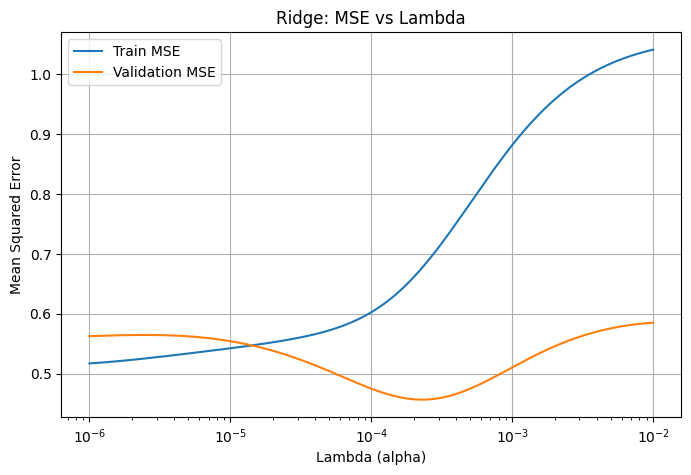

In [51]:
# lambdas entre 1e-6 y 1e-2
lambdas = np.logspace(-6, -2, 150)

mse_train = []
mse_valid = []
for lam in lambdas:
    pipeline_regu.set_params(Regularización__alpha = lam)
    pipeline_regu =Pipeline(
    [
        ('Column Transformer', ct),
        ('Scaler', sscaler),
        ('Regularización', regu)

    ]
    )
    # Entrenar
    pipeline_regu.fit(X_train, Y_train)

    # Predicciones
    y_pred_train = pipeline_regu.predict(X_train)
    y_pred_valid = pipeline_regu.predict(X_valid)

    # Guardar MSE
    mse_train.append(mean_squared_error(Y_train, y_pred_train))
    mse_valid.append(mean_squared_error(Y_valid, y_pred_valid))




#Gráfico
plt.figure(figsize=(8,5))
plt.plot(lambdas, mse_train, label="Train MSE")
plt.plot(lambdas, mse_valid, label="Validation MSE")
plt.xscale("log")  # eje x en log para ver mejor los lambda
plt.xlabel("Lambda (alpha)")
plt.ylabel("Mean Squared Error")
plt.title("Ridge: MSE vs Lambda")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
best_lamda_index = np.argmin(mse_valid) #encuentra el índice que minimiza el ECM
best_lambda = lambdas[best_lamda_index]
print(f'El lambda que minimiza el MSE de validación es {best_lambda}')

El lambda que minimiza el MSE de validación es 0.00023036479376536948


In [53]:
pipeline_regu.set_params(Regularización__alpha = best_lambda)
pipeline_regu.fit(X_train, Y_train)

X_test = mtest[cat + num]
Y_test = mtest['Selling_Price']

Y_hat_test = pipeline_regu.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_hat_test)

print(f'El MSE de testeo es {mse_test}')

El MSE de testeo es 0.34117206340659006
